# Importation Station

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.cross_validation import train_test_split
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.svm import LinearSVC, SVC
from imblearn.under_sampling import RandomUnderSampler

plt.style.use("seaborn")
%matplotlib inline

%load_ext autotime

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Make DataFrame and Extract Features

## Read Initial Data

In [2]:
# df= pd.read_csv("us-perm-visas.zip")
# df.head()

time: 691 µs


## Extract Features of Interest

In [3]:
# df_feat=df[['class_of_admission','country_of_citizenship',
#             'country_of_citzenship','case_status', 'employer_state','foreign_worker_info_city',
#             'foreign_worker_info_education','foreign_worker_info_major',
#            'application_type', 'fw_info_birth_country', 'job_info_alt_occ_job_title','job_info_education',
#             'wage_offer_from_9089']]
# df_feat.head()
# del df

time: 1.3 ms


# Pickle and Store Features of Interest into CSV

In [4]:
# with open('visa.pkl', 'wb') as picklefile:
#              pickle.dump(df_feat, picklefile)

time: 777 µs


In [5]:
# with open("visa.pkl", 'rb') as picklefile: 
#       df = pickle.load(picklefile)
# df.to_csv('visa.csv')
# df.head()

time: 879 µs


# Read Pre-Made CSV File

In [6]:
df=pd.read_csv('visa.csv')
del(df['Unnamed: 0'])
#df.head()

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


time: 1.36 s


# Data Cleaning Pt.1

## Initial NA Counts

In [7]:
df.isnull().sum()
initial_na=df.isnull().sum()

class_of_admission                22845
country_of_citizenship            20633
country_of_citzenship            353788
case_status                           0
employer_state                       42
foreign_worker_info_city         135297
foreign_worker_info_education    135309
foreign_worker_info_major        154972
application_type                 239093
fw_info_birth_country            223928
job_info_alt_occ_job_title       226962
job_info_education               135282
wage_offer_from_9089             114771
dtype: int64

time: 261 ms


## Remove Withdrawn Applications and Combine Expired with Certified

In [8]:
df=df[(df.case_status!='Withdrawn')]
df=df.replace({'Certified-Expired':'Certified'})

time: 821 ms


In [9]:
df.case_status.unique()

array(['Certified', 'Denied'], dtype=object)

time: 16.8 ms


## Combine Repeated Columns

In [10]:
df.country_of_citizenship.fillna(df.country_of_citzenship, inplace=True)
df=df.drop('country_of_citzenship', axis=1)
#df.isnull().sum()

time: 87.6 ms


In [11]:
df.foreign_worker_info_education.fillna(df.job_info_education, inplace=True)
df=df.drop('job_info_education', axis=1)
#df.isnull().sum()

time: 108 ms


## Fill Na's
**Idea:**
1. Ignore Target Variable When Filling NA's

**Structure for Each Variable:**
1. Read Values Counts
2. Fill in As Needed

In [12]:
def impute(df, series, col_name, merge_cols):
    merged_frame = pd.merge(df, series, how='left', 
                             left_on=merge_cols, 
                             right_on=merge_cols)
    merged_frame[col_name+'_x'].fillna(merged_frame[col_name+'_y'],inplace=True)
    merged_frame.rename(columns={col_name+'_x':col_name}, inplace=True)
    merged_frame.drop([col_name+'_y'], axis=1, inplace=True)
    return merged_frame

time: 3.48 ms


In [13]:
def mode(a):
    u, c = np.unique(a, return_counts=True)
    return u[c.argmax()]

time: 1.73 ms


### Country of Citizenship= Fill using the mode by education level

In [14]:
country_fill_series = df[~df['country_of_citizenship'].isnull()].groupby(['foreign_worker_info_education']
                                                                        ).country_of_citizenship.apply(mode
                                                                                                      ).reset_index()
#country_fill_series

time: 263 ms


In [15]:
df=impute(df, country_fill_series, 'country_of_citizenship',['foreign_worker_info_education'])
#df.isnull().sum()

time: 473 ms


### Destination State= Fill using overall mode

In [16]:
# df.employer_state.unique()

time: 957 µs


In [17]:
state_fill_series=df['employer_state'].mode()
# state_fill_series

time: 28.1 ms


In [18]:
df.employer_state.fillna('CALIFORNIA', inplace=True)
# df.isnull().sum()

time: 21.8 ms


### Origin City= Fill using mode of given country

In [19]:
# df.foreign_worker_info_city.unique()

time: 689 µs


In [20]:
origin_fill_series = df[~df['foreign_worker_info_city'].isnull()].groupby(['country_of_citizenship']
                                                                         ).foreign_worker_info_city.apply(mode
                                                                                                         ).reset_index()
# origin_fill_series

time: 290 ms


In [21]:
df = impute(df, origin_fill_series, 'foreign_worker_info_city',['country_of_citizenship'])
# df.isnull().sum()

time: 478 ms


### Education Level= Fill using Country and Visa Type

In [22]:
# df.foreign_worker_info_education.unique()

time: 533 µs


In [23]:
education_fill_series = df[~df['foreign_worker_info_education'].isnull()].groupby(['country_of_citizenship',
                                                                                   'class_of_admission']
                                                                                 ).foreign_worker_info_education.apply(mode
                                                                                                                      ).reset_index()
# education_fill_series

time: 415 ms


In [24]:
df = impute(df, education_fill_series, 'foreign_worker_info_education', ['country_of_citizenship',
                                                                                   'class_of_admission'])
# df.isnull().sum()

time: 511 ms


### Major= Fill with mode of visa type / country of origin / education / destination

In [25]:
# df.foreign_worker_info_major.value_counts()

time: 903 µs


In [26]:
major_fill_series = df[~df['foreign_worker_info_major'].isnull()].groupby(['country_of_citizenship',
                                                                               'class_of_admission',
                                                                               'foreign_worker_info_education',
                                                                               'employer_state']
                                                                             ).foreign_worker_info_major.apply(mode
                                                                                                              ).reset_index()
# major_fill_series

time: 2.53 s


In [27]:
df = impute(df, major_fill_series, 'foreign_worker_info_major',['country_of_citizenship',
                                                                               'class_of_admission',
                                                                               'foreign_worker_info_education',
                                                                               'employer_state'])
# df.isnull().sum()

time: 592 ms


### Birth Country= Fill with country of citizenship

In [28]:
# df.fw_info_birth_country.unique()

time: 805 µs


In [29]:
df.fw_info_birth_country.fillna(df.country_of_citizenship, inplace=True)
# df.isnull().sum()

time: 35.3 ms


### Job Title
1. Condense Job Titles into Categories
2. Fill in missing information using mode by major, education level, and class of admission

In [30]:
# df.job_info_alt_occ_job_title.value_counts()

time: 512 µs


In [31]:
def label(row,col):
    if type(row[col])!=float:
        value=row[col].lower()
        value_case_sensitive=row[col]
    else:
        value='null'
        value_case_sensitive='null'
    programmer=['comp', 'software','developer', 'program','soft','web','application development', 'data']
    it=['IT','Information Technology','technical']
    h14=['H.14', 'H-14','H14','H. 14', 'H:14']
    medicine=['health','doctor','pharm','therapist','surgery','acupunc', 'medic', 'dent', 'vet']
    engineer=['engr','engineer','eng', 'tech']
    marketing=['market','sale']
    finance=['financ', 'consult','account','tax','audit']
    other_biz=['analyst', 'business','anlyst','associate','manag','project']
    academic=['analys', 'assistant', 'research', 'teach','academic', 'educ']
    related=['related occupation', 'related', 'any', 'similar','experience', 'alternate']
    h11=['H-11','H11','H.11', 'H. 11']
    fourteen=['14']
    nan=['null']
    if value=='null' or value_case_sensitive=='null':
        return None
    if any(keyword in value for keyword in programmer):
        return 'programming'
    if any(keyword in value_case_sensitive for keyword in it):
        return 'IT'
    if any(keyword in value_case_sensitive for keyword in h14):
        return 'H.14'
    if any(keyword in value for keyword in medicine):
        return 'medicine'
    if any(keyword in value for keyword in engineer):
        return 'engineer'
    if any(keyword in value for keyword in marketing):
        return 'marketing/sales'
    if any(keyword in value for keyword in finance):
        return 'finance/consulting/tax'
    if any(keyword in value for keyword in other_biz):
        return 'business'
    if any(keyword in value for keyword in academic):
        return 'academic'
    if any(keyword in value_case_sensitive for keyword in h11):
        return 'h11'
    if any(keyword in value for keyword in related):
        return 'related'
    if any(keyword in value_case_sensitive for keyword in fourteen):
        return '14'
    return 'Other'

time: 9.9 ms


In [32]:
df['job_category']=df.apply (lambda row: label(row, 'job_info_alt_occ_job_title'),axis=1)
# df.job_category.value_counts()

time: 7.65 s


In [33]:
# df.job_info_alt_occ_job_title[df.job_category=="Other"].value_counts()

time: 650 µs


In [34]:
job_type_fill_series = df[~df['job_category'].isnull()].groupby(['foreign_worker_info_major',
                                                                               'foreign_worker_info_education',
                                                                               'class_of_admission']
                                                                             ).job_category.apply(mode).reset_index()
# job_type_fill_series

time: 2.59 s


In [35]:
df = impute(df, job_type_fill_series, 'job_category',['foreign_worker_info_major',
                                                                               'foreign_worker_info_education',
                                                                               'class_of_admission'])
# df.isnull().sum()

time: 600 ms


In [36]:
df=df.drop('job_info_alt_occ_job_title', axis=1)

time: 39.7 ms


### Visa Type (Class of Admission)

In [37]:
# df.class_of_admission.unique()

time: 488 µs


In [38]:
visa_fill_series = df[~df['class_of_admission'].isnull()].groupby(['foreign_worker_info_education'
                                                                  ]).class_of_admission.apply(mode).reset_index()
# visa_fill_series

time: 309 ms


In [39]:
df = impute(df, visa_fill_series, 'class_of_admission',['foreign_worker_info_education'])

time: 449 ms


### Drop Columns 

In [40]:
df=df.drop(['foreign_worker_info_major', 'fw_info_birth_country', 'application_type','wage_offer_from_9089'], axis=1)

time: 38.3 ms


### Final NA Counts Initial Dataset

In [41]:
df.isnull().sum()
final_na=df.isnull().sum()

class_of_admission                6168
country_of_citizenship              23
case_status                          0
employer_state                       0
foreign_worker_info_city            37
foreign_worker_info_education     6492
job_category                     56640
dtype: int64

time: 160 ms


# Data Cleaning Pt.2- Joining Tables to Reduce Categorical Data

## Change Cities to Population

In [255]:
cities_pop = pd.read_excel('global-city-population-estimates.xls', sheet_name='CITIES-OVER-300K')

time: 184 ms


In [256]:
city_df = cities_pop.loc[:,['Urban Agglomeration', '2015']].rename(columns = {'Urban Agglomeration': 'city', '2015': 'pop'})

time: 3.23 ms


In [257]:
city_df['city'] = city_df['city'].str.upper()
city_df.set_index('city', inplace=True)
city_df_dict = city_df.to_dict()

time: 3.59 ms


In [258]:
df['foreign_worker_city_pop'] = df['foreign_worker_info_city'].apply(lambda x: city_df_dict['pop'].get(x, x))

time: 176 ms


In [259]:
replacements={}
for city in df.loc[df['foreign_worker_city_pop'].apply(type)==str,'foreign_worker_city_pop' ]:
    for value in city_df.index:
        if city in value:
            replacements[city]=value

time: 40.5 s


In [260]:
df['foreign_worker_city_pop'] = df['foreign_worker_city_pop'].apply(lambda x: replacements.get(x,x)).apply(lambda x: city_df_dict['pop'].get(x, x))

time: 333 ms


In [264]:
df.loc[df['foreign_worker_city_pop'].apply(type)==str, 'foreign_worker_city_pop' ].value_counts()

SUNNYVALE                   5697
FREMONT                     4280
JERSEY CITY                 3796
SANTA CLARA                 3768
IRVING                      3243
BELLEVUE                    3199
MOUNTAIN VIEW               2781
REDMOND                     2612
HILLSBORO                   2245
BROOKLYN                    2215
EDISON                      1573
PLANO                       1513
IRVINE                      1409
MILPITAS                    1379
ALPHARETTA                  1037
HERNDON                      998
CUPERTINO                    918
ARLINGTON                    772
BLOOMINGTON                  767
CHANDLER                     733
CARY                         720
FOLSOM                       715
TORRANCE                     699
SAN MATEO                    693
FOSTER CITY                  686
MORRISVILLE                  685
FARMINGTON HILLS             678
OVERLAND PARK                659
TROY                         655
SCHAUMBURG                   641
          

time: 96.3 ms


In [263]:
df['foreign_worker_city_pop'].apply(lambda x: 300 if type(x)==str else x)

0          1044.443
1           300.000
2          1729.674
3          9773.746
4         18593.220
5           300.000
6          5638.045
7         18593.220
8         18593.220
9          5638.045
10        18593.220
11         1729.674
12         1729.674
13         5638.045
14          300.000
15         1729.674
16        18593.220
17         5638.045
18          300.000
19         2916.183
20        12309.530
21        18593.220
22         5638.045
23         1729.674
24         5638.045
25         5638.045
26         1729.674
27         1729.674
28          300.000
29         5638.045
            ...    
356138     3300.075
356139      300.000
356140      300.000
356141     1615.570
356142      613.098
356143      300.000
356144    18593.220
356145      300.000
356146      300.000
356147      300.000
356148      300.000
356149      780.190
356150      300.000
356151      300.000
356152      300.000
356153     1687.514
356154      300.000
356155      347.984
356156      300.000


time: 160 ms


In [252]:
df['foreign_worker_city_pop'].value_counts()

1729.674                               88744
18593.22                               21183
5638.045                                9541
12309.53                                7877
9773.746                                7778
3300.075                                6228
SUNNYVALE                               5697
FREMONT                                 4280
JERSEY CITY                             3796
SANTA CLARA                             3768
IRVING                                  3243
BELLEVUE                                3199
8744.835                                2917
3248.724                                2882
MOUNTAIN VIEW                           2781
REDMOND                                 2612
5817.221                                2475
3107.034                                2449
1684.433                                2294
HILLSBORO                               2245
BROOKLYN                                2215
1615.57                                 2037
5142.14   

time: 51.9 ms


In [262]:
city_df

,pop
city,
TOKYO,38001.018
DELHI,25703.168
SHANGHAI,23740.778
SÃO PAULO,21066.245
MUMBAI (BOMBAY),21042.538
CIUDAD DE MÉXICO (MEXICO CITY),20998.543
BEIJING,20383.994
KINKI M.M.A. (OSAKA),20237.645
AL-QAHIRAH (CAIRO),18771.769


time: 21.5 ms


## Fixing Duplicates in States

In [211]:
state_list = pd.read_html('https://www.infoplease.com/state-abbreviations-and-state-postal-codes')
state_abbr = pd.concat([state_list[0],state_list[1]], axis=0).reset_index()
state_abbr['State/District'].fillna(state_abbr['Territory/Associate'],inplace=True)
state_abbr.drop(['Territory/Associate', 'index'], axis=1, inplace=True)

time: 786 ms


/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




In [212]:
state_abbr.drop('Abbreviation', axis=1, inplace=True)
state_abbr.set_index('Postal Code', inplace=True)
state_abbr['State/District'] = state_abbr['State/District'].str.upper()
state_abbr_dict = state_abbr.to_dict()

time: 3.75 ms


In [217]:
state_abbr_dict['State/District']['NORTHERN MARIANAS']='NORTHERN MARIANA ISLANDS'
state_abbr_dict['State/District']['BC']='BRITISH COLUMBIA'

{'State/District': {'AL': 'ALABAMA',
  'AK': 'ALASKA',
  'AZ': 'ARIZONA',
  'AR': 'ARKANSAS',
  'CA': 'CALIFORNIA',
  'CO': 'COLORADO',
  'CT': 'CONNECTICUT',
  'DE': 'DELAWARE',
  'DC': 'DISTRICT OF COLUMBIA',
  'FL': 'FLORIDA',
  'GA': 'GEORGIA',
  'HI': 'HAWAII',
  'ID': 'IDAHO',
  'IL': 'ILLINOIS',
  'IN': 'INDIANA',
  'IA': 'IOWA',
  'KS': 'KANSAS',
  'KY': 'KENTUCKY',
  'LA': 'LOUISIANA',
  'ME': 'MAINE',
  'MD': 'MARYLAND',
  'MA': 'MASSACHUSETTS',
  'MI': 'MICHIGAN',
  'MN': 'MINNESOTA',
  'MS': 'MISSISSIPPI',
  'MO': 'MISSOURI',
  'MT': 'MONTANA',
  'NE': 'NEBRASKA',
  'NV': 'NEVADA',
  'NH': 'NEW HAMPSHIRE',
  'NJ': 'NEW JERSEY',
  'NM': 'NEW MEXICO',
  'NY': 'NEW YORK',
  'NC': 'NORTH CAROLINA',
  'ND': 'NORTH DAKOTA',
  'OH': 'OHIO',
  'OK': 'OKLAHOMA',
  'OR': 'OREGON',
  'PA': 'PENNSYLVANIA',
  'RI': 'RHODE ISLAND',
  'SC': 'SOUTH CAROLINA',
  'SD': 'SOUTH DAKOTA',
  'TN': 'TENNESSEE',
  'TX': 'TEXAS',
  'UT': 'UTAH',
  'VT': 'VERMONT',
  'VA': 'VIRGINIA',
  'WA': 'WASHIN

time: 4.48 ms


In [219]:
df['employer_state']=df['employer_state'].apply(lambda x: state_abbr_dict['State/District'].get(x, x))

time: 156 ms


# Dummify Variables

In [46]:
[(col, len(df[col].value_counts())) for col in df.columns]

[('class_of_admission', 57),
 ('country_of_citizenship', 201),
 ('case_status', 2),
 ('employer_state', 113),
 ('foreign_worker_info_city', 9466),
 ('foreign_worker_info_education', 7),
 ('job_category', 13)]

time: 350 ms


In [47]:
df2=df.drop(['case_status'], axis=1)
df3=pd.get_dummies(df2)
df3['case_status']=df.case_status

time: 1min 36s


In [48]:
df2=df3

time: 31.6 ms


# Class Imbalances

## Visualize

In [49]:
number_data=df2.case_status.value_counts()

time: 44.7 ms


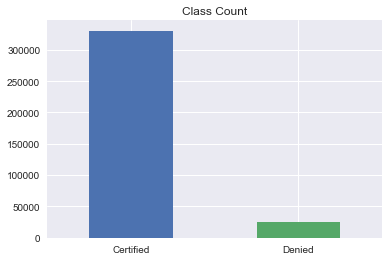

time: 252 ms


In [50]:
number_data.plot(kind='bar', title='Class Count', rot=0);

In [51]:
X=df2.drop(['case_status'], axis=1)
y=df2.case_status

time: 25 s


In [52]:
Counter(df2.case_status)

Counter({'Certified': 330519, 'Denied': 25649})

time: 65.3 ms


## Undersample

In [53]:
rus = RandomUnderSampler()
X_under, y_under = rus.fit_sample(X,y)

time: 1min 17s


In [54]:
Counter(y_under)

Counter({'Certified': 25649, 'Denied': 25649})

time: 6.73 ms


In [55]:
X_underdf=pd.DataFrame(X_under, columns = X.columns)
y_underdf=pd.DataFrame(y_under, columns=['case_status'])

time: 11.7 ms


In [56]:
df_under=X_underdf.join(y_underdf)

time: 12 s


In [57]:
df_under.head()

,class_of_admission_A-3,class_of_admission_A1/A2,class_of_admission_AOS,class_of_admission_AOS/H-1B,class_of_admission_B-1,class_of_admission_B-2,class_of_admission_C-1,class_of_admission_C-3,class_of_admission_D-1,class_of_admission_E-1,...,job_category_academic,job_category_business,job_category_engineer,job_category_finance/consulting/tax,job_category_h11,job_category_marketing/sales,job_category_medicine,job_category_programming,job_category_related,case_status
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Certified
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Certified
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Certified
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Certified
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Certified


time: 40.4 ms


# Store as CSV

In [58]:
# with open('clean_data1.pkl', 'wb') as picklefile:
#              pickle.dump(df_under, picklefile)

time: 913 µs


In [59]:
# with open("clean_data1.pkl", 'rb') as picklefile: 
#       df = pickle.load(picklefile)
# df.to_csv('clean_data1.csv')
# df.head()

time: 536 µs


# Modeling

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
import seaborn as sns
from sklearn.model_selection import cross_val_score
import matplotlib as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn import naive_bayes

time: 113 ms


In [73]:
def print_confusion_matrix(confusion_matrix, model, class_names, figsize = (10,7), fontsize=18):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(model)
    return fig

time: 2.76 ms


## Train/Test Split on Random Subset of Data

In [62]:
mini_sample=df_under.sample(n=15000)
X=mini_sample.drop(['case_status'], axis=1)
y=mini_sample.case_status

time: 888 ms


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

time: 389 ms


In [64]:
train_df=X_train.join(pd.DataFrame(y_train))
test_df=X_test.join(y_test)

time: 55.2 ms


## Apply Standard Scalar

In [66]:
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

time: 3.54 s


In [67]:
train_df_scaled=pd.DataFrame(X_train_scaled).join(y_train)
test_df_sclaed=pd.DataFrame(X_test_scaled).join(y_test)

time: 511 ms


## Make List of Models to Compare

In [68]:
models = [RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=10), DecisionTreeClassifier(max_depth=None),
          LogisticRegression(C=0.1), SGDClassifier(loss='log', random_state=42, alpha=0.01), naive_bayes.GaussianNB(),
         naive_bayes.BernoulliNB(), naive_bayes.MultinomialNB()]
model_names = ["Random Forest", "Decision Tree",'Logistic','SGD-Log', 'Naive-Bayes Gaussian',
              'Naive-Bayes Bernoulli', 'Naive-Bayes Multinomial']

time: 2.88 ms


## Compare Models- ROC Curves

In [142]:
roc_plotting_stuff = []

for clf, name in zip(models, model_names):
    if 'Bayes' not in name:
        clf.fit(X_train_scaled, y_train)
        preds = clf.predict_proba(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        preds = clf.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, preds[:,1], pos_label='Denied')
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


time: 29.1 s


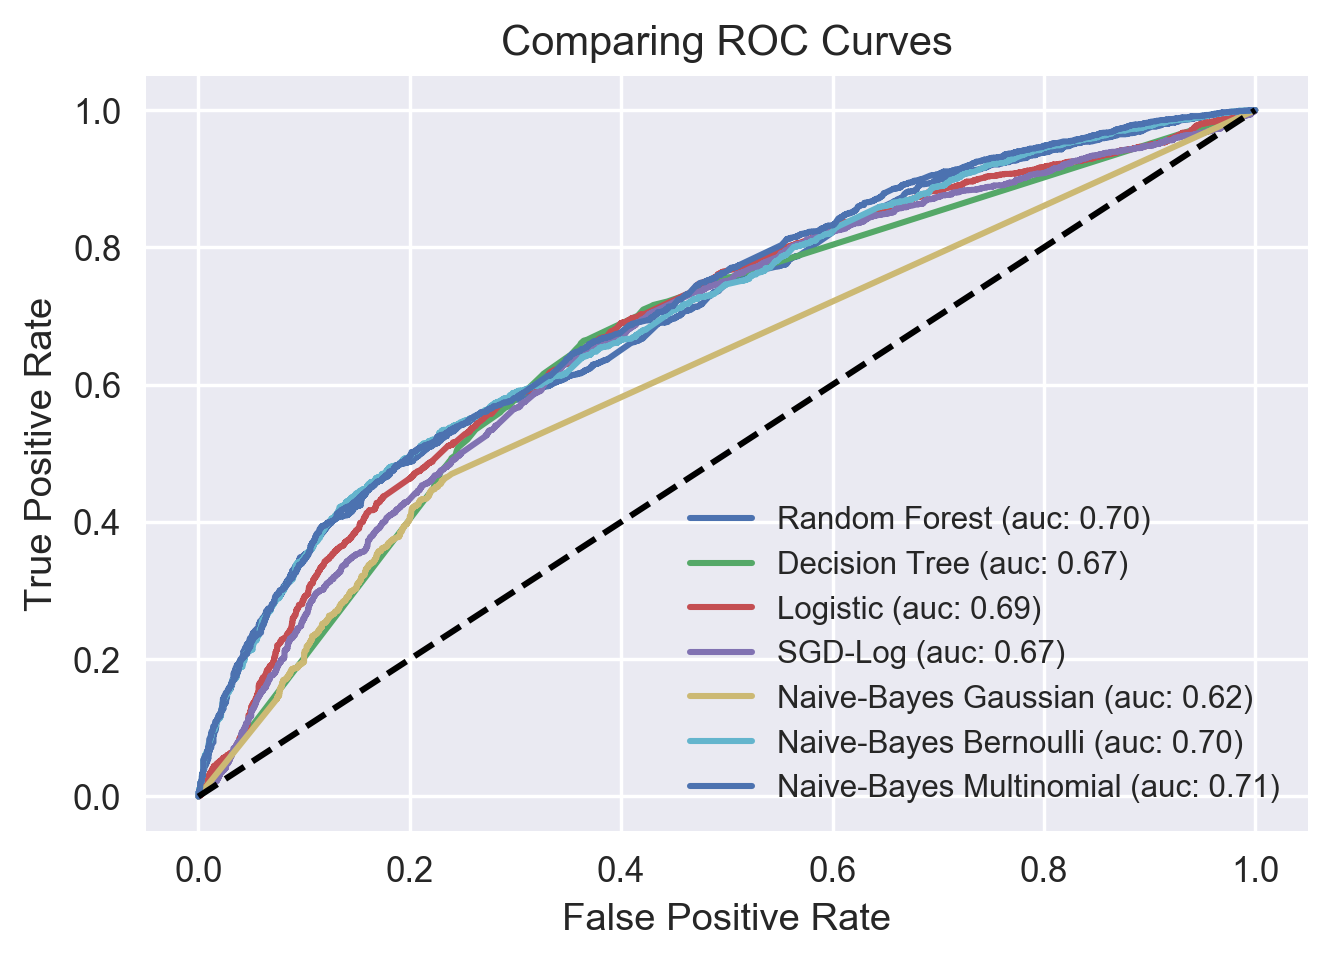

time: 494 ms


In [143]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.legend(loc='lower right', fontsize=9)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves");

## Compare Models- Confusion Matrices

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


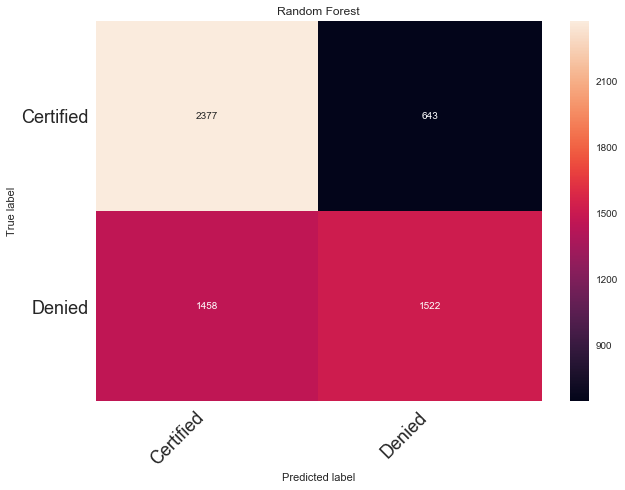

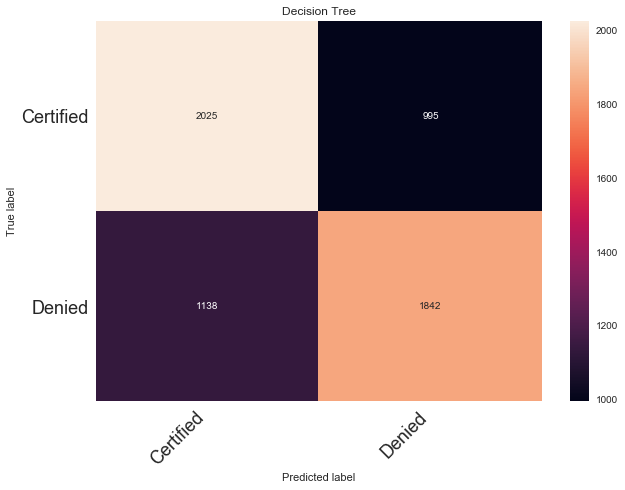

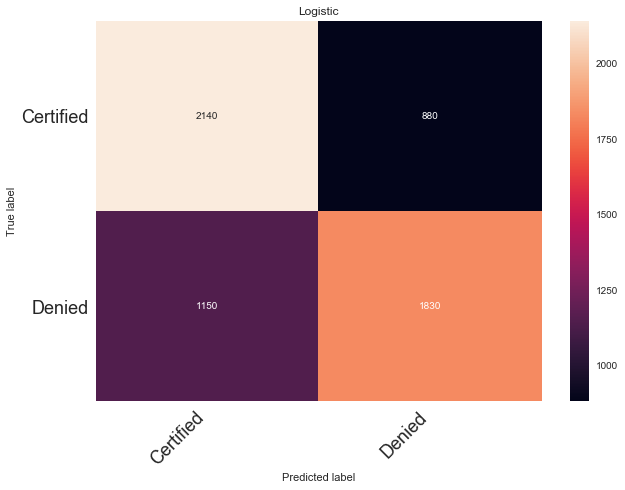

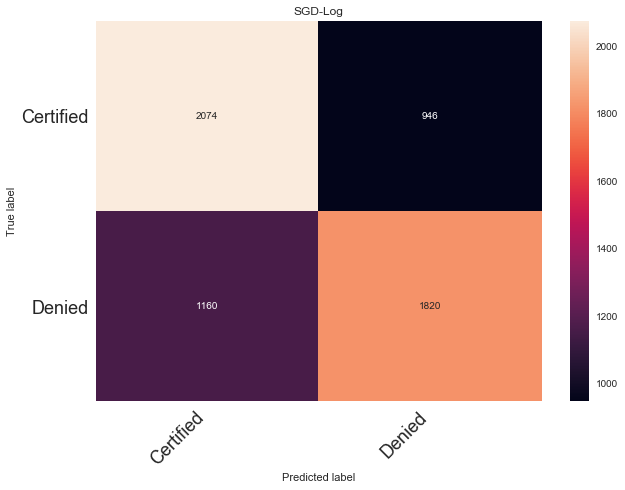

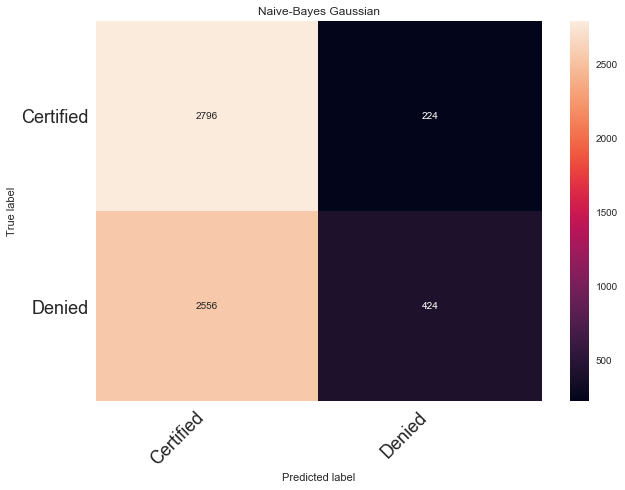

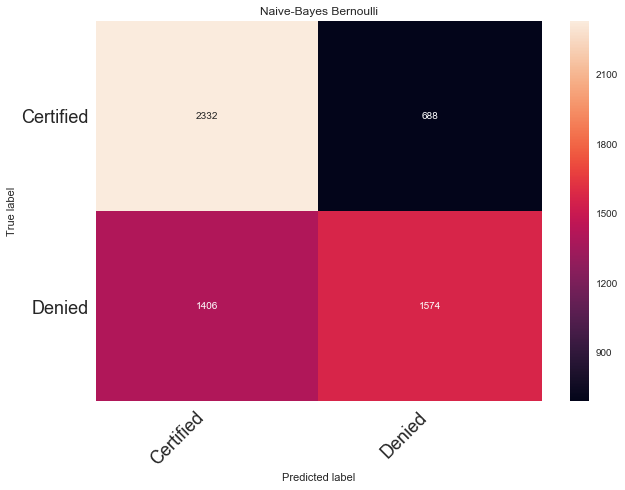

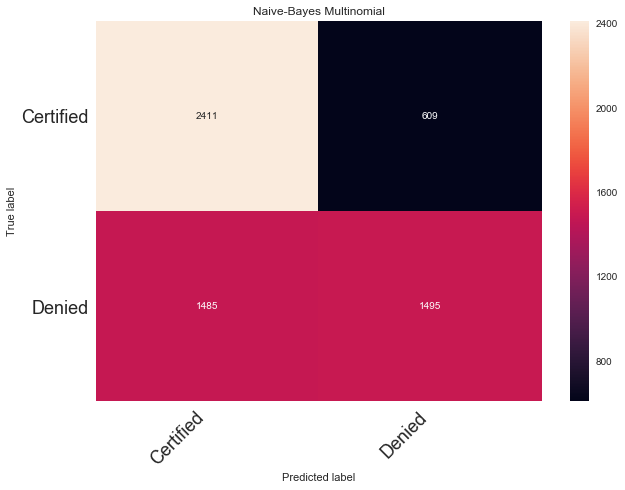

time: 20.7 s


In [74]:
for clf, name in zip(models, model_names):
    if 'Bayes' not in name:
        clf.fit(X_train_scaled, y_train)
        preds = clf.predict_proba(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    cm = print_confusion_matrix(conf_mat, name, ['Certified', 'Denied'])

## Which Features are Important

In [75]:
for imp, name in sorted(zip(models[0].feature_importances_, X_train.columns))[-10:]:
    print(f"{name} {imp}")

class_of_admission_L-1 0.021818979874395725
foreign_worker_info_education_Master's 0.02633100377268432
class_of_admission_B-2 0.02871572251527192
job_category_programming 0.035678108290026996
class_of_admission_Not in USA 0.03763038970935705
class_of_admission_EWI 0.04154383039018114
foreign_worker_info_education_None 0.04387363062146028
class_of_admission_H-1B 0.045731477934316936
country_of_citizenship_MEXICO 0.04746906652879477
country_of_citizenship_INDIA 0.055898044283549594
time: 121 ms


## Apply Chosen Model to Full Train and Score on Test

In [76]:
lm = LogisticRegression()
lm.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

time: 1.7 s


In [77]:
y_predict = lm.predict(X_train)
lm.score(X_train, y_train)

0.7175555555555555

time: 1.09 s


In [79]:
y_predict_test = lm.predict(X_test)
lm.score(X_test, y_test)

0.658

time: 690 ms


In [144]:
nbm=naive_bayes.MultinomialNB()
nbm.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

time: 610 ms


In [145]:
y_predict2 = nbm.predict(X_train)
nbm.score(X_train, y_train)

0.6887777777777778

time: 1.3 s


In [147]:
y_predict_test2 = nbm.predict(X_test)
nbm.score(X_test, y_test)

0.651

time: 873 ms


## Check How Many Data Points are Needed for Final Model

(-1, 1)

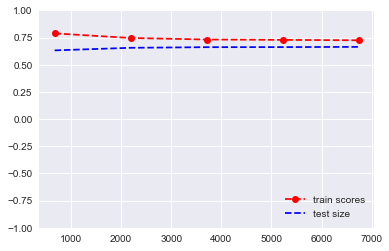

time: 22.3 s


In [80]:
train_sizes, train_scores, test_scores = learning_curve(lm, X_train, y_train, cv= 4)

ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

learn_df = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})
learn_df

plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test size')
plt.legend(loc='lower right')
plt.ylim(-1,1)

This implies that approximately 3000 data points were needed to test this model. Hence the initial random sample  is justified.

# Making Predictions

In [103]:
df.columns

Index(['class_of_admission', 'country_of_citizenship', 'case_status',
       'employer_state', 'foreign_worker_info_city',
       'foreign_worker_info_education', 'job_category'],
      dtype='object')

time: 2.82 ms


In [134]:
def prediction(features):
    test_case = pd.DataFrame({'class_of_admission':features['class_of_admission'],
                      'country_of_citizenship': features['country_of_citizenship'], 
                      'employer_state': features['employer_state'],
                      'foreign_worker_info_city': features['foreign_worker_info_city'],
                      'foreign_worker_info_education': features['foreign_worker_info_education'],
                      'job_category': features['job_category']}, index=[0])
    
    test_case_dummies=pd.get_dummies(test_case)
    missing_cols=set(X_train.columns) - set(test_case_dummies.columns)
    for c in missing_cols:
        test_case_dummies[c] = 0
    test_case_dummies = test_case_dummies[X_train.columns]
    
    prob_certified = lm.predict_proba(test_case_dummies)[0, 1] 
    outcome=''
    if int(prob_certified > 0.5):
        outcome+='Certified Visa'
    else:
        outcome+='Denied Visa'
    result = {
        'prediction': outcome,
        'prob_certified': prob_certified
    }
    return result

time: 3.4 ms


In [135]:
example = {
  'class_of_admission': 'H-1B',
  'country_of_citizenship': 'INDIA',
  'employer_state': 'NJ',
  'foreign_worker_info_city': 'BROOKLYN',
  'foreign_worker_info_education': 'High School',
  'job_category': 'Other'
}

time: 2.33 ms


In [136]:
prediction(example)

{'prediction': 'Certified Visa', 'prob_certified': 0.6410447266819208}

time: 9.65 s


# You Can't Tell a Story Without a Plot!

In [151]:
import plotly.plotly as py

time: 2.2 s


## Data Cleaning, Before and After

In [150]:
df.columns

Index(['class_of_admission', 'country_of_citizenship', 'case_status',
       'employer_state', 'foreign_worker_info_city',
       'foreign_worker_info_education', 'job_category'],
      dtype='object')

time: 4.14 ms


## Cloropleth

In [152]:
data = [ dict(
        type = 'choropleth',
        locations = df['CODE'],
        z = df['case_status'],
        text = df['country_of_citizenship'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '$',
            title = 'GDP<br>Billions US$'),
      ) ]

layout = dict(
    title = '2014 Global GDP<br>Source:\
            <a href="https://www.cia.gov/library/publications/the-world-factbook/fields/2195.html">\
            CIA World Factbook</a>',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

KeyError: 'CODE'

time: 279 ms


1. cloropleth
2. flask